Get data

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 14.32 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [2]:
# check what files are in the Pubmed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
# !ls pubmed-rct/

dev.txt  test.txt  train.txt


In [3]:
# start our experiments using the 20k dataset with numbers replaced by @ sign

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
# Check all of the filenames in the target directory

import os
filenames = [data_dir + filename for filename in os.listdir(data_dir) ]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# Preprocess the data



In [5]:
# create function to read lines of a document

def get_lines(filename):

  with open(filename, "r") as f:
    return f.readlines()



In [6]:
# Let's read in the training lines

train_lines = get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
len(train_lines)

210040

In [8]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ''
    abstract_samples = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower() if len(target_text_split) > 1 else ''
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)
        else:
            abstract_lines += line

    return abstract_samples


In [9]:
txt = "hello, welcome to my world"

x = txt.startswith("hello")

print(x)

True


Get data from file and preprocess it

In [10]:
%%time

train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 887 ms, sys: 191 ms, total: 1.08 s
Wall time: 1.76 s


(180040, 30212, 30135)

In [11]:
# Check the first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)
train_df.head(3)


,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11


In [13]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


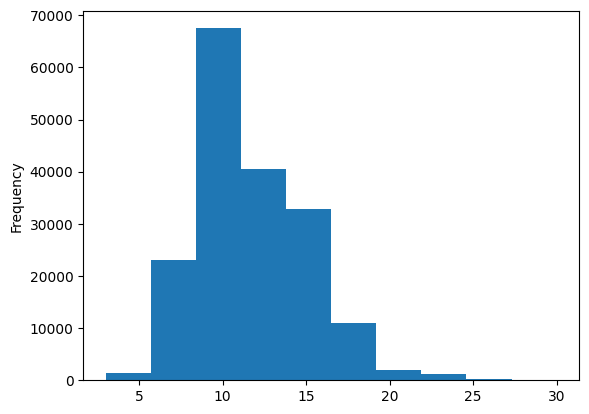

In [14]:
train_df.total_lines.plot.hist();

In [15]:
# Get list of sentences

In [16]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

<Axes: ylabel='Frequency'>

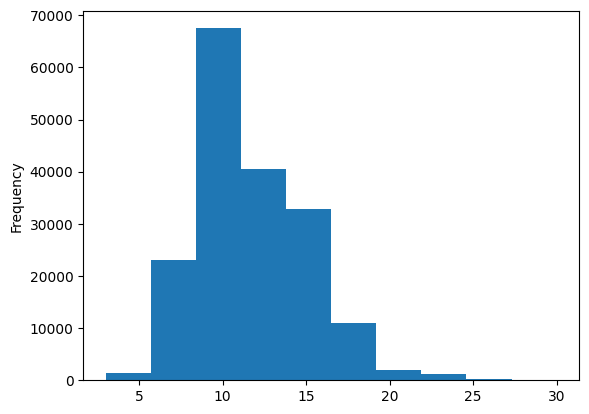

In [18]:
train_df.total_lines.plot.hist()

Make Numeric labels

In [19]:
# one hot encode labels

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
label_encoder = LabelEncoder()
train_labels_one_hot = label_encoder.fit_transform(
    train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = label_encoder.fit_transform(
    val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = label_encoder.fit_transform(
    test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([3, 2, 2, ..., 4, 1, 1])

In [20]:
import sklearn
print(sklearn.__version__)

1.5.2


In [21]:
# get class names and number of classes from LabelEncoder instance

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names


(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

Model0: getting a baseline

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf",MultinomialNB() )

])

model_0.fit(
    X = train_sentences,
    y = train_labels_one_hot
)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
# Download helper function script

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-09-24 05:35:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-09-24 05:35:38 (14.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
from helper_functions import calculate_results

In [26]:
baseline_results = calculate_results(
    y_true = val_labels_one_hot,
    y_pred = baseline_preds
)

baseline_results


{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Preparing our data for deep sequence models

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [28]:
# How long is each sentence on average ???

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

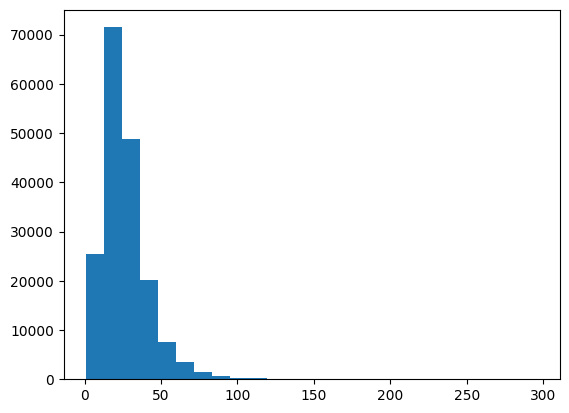

In [29]:
# What is the distribution look like ????

import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=25);

# Create text vectorizer layer



In [30]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [31]:
# How many words in your vocab ???
max_tokens = 68000

In [32]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_seq_len
)


In [33]:
# Adapt text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [34]:
# Test our text vectorizer on random sentences

import random
target_sentence = random.choice(train_sentences)
print('Text:', target_sentence)
print('Length of text:', len(target_sentence))
print('Vectorized Text:', text_vectorizer(target_sentence))

Text: this prospective study compared concentrations of urinary electrolytes and plasma adh and bnp in ( @ ) children with sdb and ne ( study group ) and an age - and sex-matched control group of children with sdb without ne , and ( @ ) the study group before and @-month after t&a .
Length of text: 277
Vectorized Text: tf.Tensor(
[   23   241    17    34   341     4   616  7886     3   249 15230     3
  3107     5   109     7  8186     3  5190    17    13     3    26   103
     3 14468    35    13     4   109     7  8186   159  5190     3     2
    17    13   129     3   178    21  2906     0     0     0     0     0
     0     0     0     0     0     0     0], shape=(55,), dtype=int64)


In [35]:
# How many words in our training vocab

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print("Number of words in vocab:", len(rct_20k_text_vocab))
print("Most common words in vocab:", rct_20k_text_vocab[:5])
print("Least common words in vocab:", rct_20k_text_vocab[-5:])

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# Get the config of our text vectorizer

text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

Create custom text embedding

In [37]:
token_embed = layers.Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim =128,
    mask_zero=True,
    name = "token_embedding"
)

In [38]:
# Show example embedding

print("Sentence before vectorization:", target_sentence)
vectorized_sentence = text_vectorizer([target_sentence])
print("Sentence after vectorization:", vectorized_sentence)
embedded_sentence = token_embed(vectorized_sentence)
print("Sentence after embedding:", embedded_sentence)
print("Embedded sentence shape:",embedded_sentence.shape )

Sentence before vectorization: this prospective study compared concentrations of urinary electrolytes and plasma adh and bnp in ( @ ) children with sdb and ne ( study group ) and an age - and sex-matched control group of children with sdb without ne , and ( @ ) the study group before and @-month after t&a .
Sentence after vectorization: tf.Tensor(
[[   23   241    17    34   341     4   616  7886     3   249 15230     3
   3107     5   109     7  8186     3  5190    17    13     3    26   103
      3 14468    35    13     4   109     7  8186   159  5190     3     2
     17    13   129     3   178    21  2906     0     0     0     0     0
      0     0     0     0     0     0     0]], shape=(1, 55), dtype=int64)
Sentence after embedding: tf.Tensor(
[[[-4.5467168e-05 -3.2626189e-02 -3.5592891e-02 ...  2.6382755e-02
    2.2189427e-02  1.1655927e-02]
  [ 2.0890124e-03  1.3708245e-02  6.7486055e-03 ... -1.2219977e-02
   -7.0576556e-03  3.3270065e-02]
  [ 4.4253912e-02  2.4001960e-02  3.0276

Creating datasets

In [39]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_labels_one_hot)
)

valid_dataset = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_labels_one_hot)
)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_sentences, test_labels_one_hot)
)

train_dataset


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [40]:
# Take the tensorslicedataset and turn them into prefetched datasets

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [41]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Model1: Conv1D with tokens embedding

In [42]:
# create 1D conv model to process sequences

inputs = layers.Input(shape =(1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [43]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [45]:
# Fit the model

history_model_1 = model_1.fit(
    train_dataset,
    steps_per_epoch = int(0.1*len(train_dataset)),
    epochs = 5,
    validation_data = valid_dataset,
    validation_steps = int(0.1* len(valid_dataset)),
)

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.5222 - loss: 1.1561 - val_accuracy: 0.7374 - val_loss: 0.6915
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 51s 91ms/step - accuracy: 0.7423 - loss: 0.6866 - val_accuracy: 0.7666 - val_loss: 0.6325
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.7687 - loss: 0.6265 - val_accuracy: 0.7906 - val_loss: 0.5956
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.7844 - loss: 0.6011 - val_accuracy: 0.8035 - val_loss: 0.5672
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 59s 104ms/step - accuracy: 0.7900 - loss: 0.5900 - val_accuracy: 0.7959 - val_loss: 0.5682


In [46]:
# Evaluate on whole validation dataset

model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8022 - loss: 0.5578


[0.5604365468025208, 0.8020654320716858]

In [47]:
# Make predictions

model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


(array([[5.2569479e-01, 1.6447695e-01, 7.2004437e-02, 1.9104108e-01,
         4.6782780e-02],
        [4.2813686e-01, 3.4846970e-01, 2.5770558e-02, 1.5037845e-01,
         4.7244459e-02],
        [1.8707712e-01, 3.5607642e-03, 1.0793431e-03, 8.0822808e-01,
         5.4648965e-05],
        ...,
        [2.8614862e-05, 5.0483388e-04, 3.5751085e-03, 2.0194337e-05,
         9.9587125e-01],
        [8.6879462e-02, 2.9622743e-01, 1.6489394e-01, 6.0097683e-02,
         3.9190152e-01],
        [1.4965948e-01, 7.5736207e-01, 5.6586817e-02, 1.2994649e-02,
         2.3396961e-02]], dtype=float32),
 (30212, 5))

In [48]:
# Convert pred probs to classes

model_1_preds = tf.argmax(model_1_pred_probs, axis =1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [49]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [50]:
# Calculate model_1 results

model_1_results = calculate_results(
    y_true = val_labels_one_hot,
    y_pred = model_1_preds
)
model_1_results


{'accuracy': 80.20654044750431,
 'precision': 0.8026424668499835,
 'recall': 0.802065404475043,
 'f1': 0.7986546494834293}

In [51]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

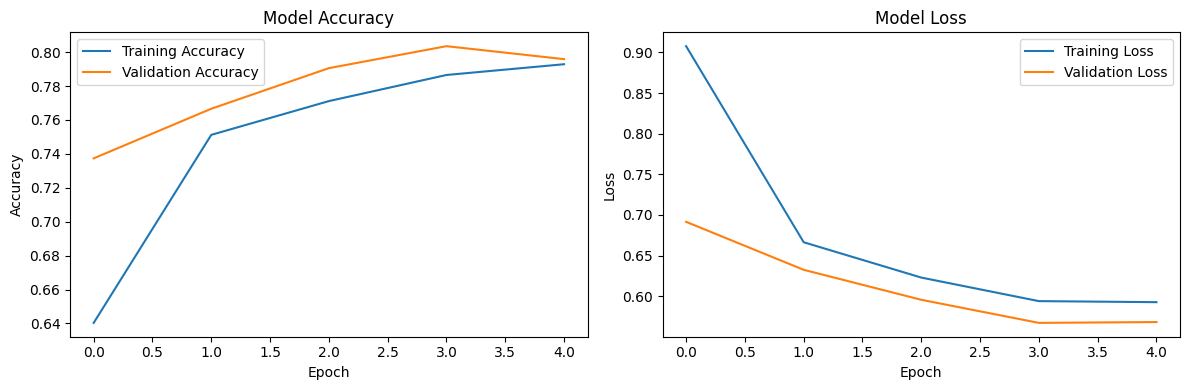

In [52]:
import matplotlib.pyplot as plt

# Retrieve accuracy and loss history from the model
history = history_model_1.history

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step


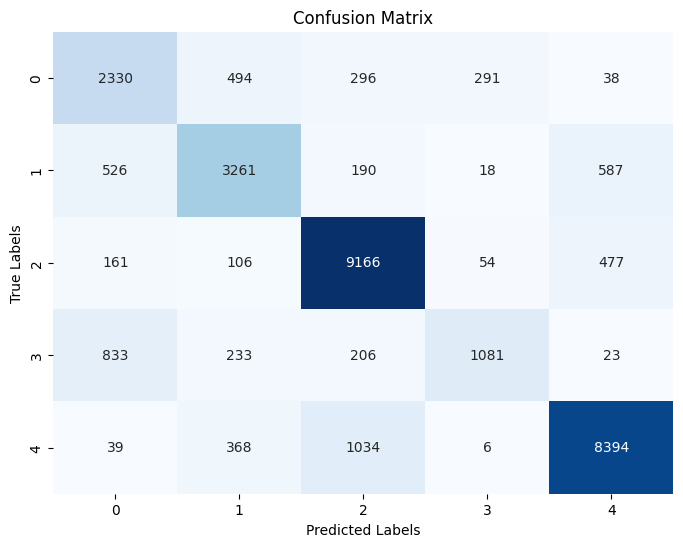

              precision    recall  f1-score   support

           0       0.60      0.68      0.64      3449
           1       0.73      0.71      0.72      4582
           2       0.84      0.92      0.88      9964
           3       0.75      0.45      0.57      2376
           4       0.88      0.85      0.87      9841

    accuracy                           0.80     30212
   macro avg       0.76      0.72      0.73     30212
weighted avg       0.80      0.80      0.80     30212



In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Get the true labels and predictions
# Assuming valid_dataset is your validation data and the labels are in the format you can use
y_true = np.concatenate([y for x, y in valid_dataset], axis=0)  # True labels
y_pred = np.argmax(model_1.predict(valid_dataset), axis=1)      # Predicted labels

# Step 2: Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Optional: Show classification report
print(classification_report(y_true, y_pred))


# Model 2: Feature extraction with pretrained token embeddings

In [54]:

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [55]:

# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
experiment @ .

Sentence after embedding:
[-0.006394   -0.02624697 -0.02356     0.0028685  -0.06116689  0.01918291
  0.03359153 -0.00866749  0.04010085  0.06685527  0.03870486  0.04954459
  0.08140836  0.07434508 -0.00922326 -0.04438761  0.00622859  0.0472296
  0.05494265 -0.05124424 -0.03158325 -0.03881174 -0.00953721  0.04510044
  0.00775135  0.03157389 -0.000741    0.01822717  0.0552933   0.06894305] (truncated output)...

Length of sentence embedding:
512


In [58]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Assuming tf_hub_embedding_layer is a TensorFlow Hub URL like a Universal Sentence Encoder
hub_url = "https://tfhub.dev/google/universal-sentence-encoder/4"  # Example for Universal Sentence Encoder

# Wrap the TensorFlow Hub embedding layer with KerasLayer
tf_hub_embedding_layer = hub.KerasLayer(hub_url, input_shape=[], dtype=tf.string, trainable=True)

# Build the model
inputs = layers.Input(shape=(), dtype=tf.string)  # Input shape for string type
pretrained_embedding = tf_hub_embedding_layer(inputs)  # Pass through the hub layer
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Summary to verify
model_2.summary()


TypeError: Exception encountered when calling layer 'keras_layer_1' (type KerasLayer).

Binding inputs to tf.function failed due to `A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
`. Received args: (<KerasTensor shape=(None,), dtype=string, sparse=None, name=keras_tensor_9>,) and kwargs: {} for signature: (inputs: TensorSpec(shape=<unknown>, dtype=tf.string, name=None)).

Call arguments received by layer 'keras_layer_1' (type KerasLayer):
  • inputs=<KerasTensor shape=(None,), dtype=string, sparse=None, name=keras_tensor_9>
  • training=None

# Model3: Conv1D with character embeddings



In [60]:
# The paper which we were replicating states they used a combination of token and character-level embeddings



In [62]:


# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'e x p e r i m e n t   @   .'

In [63]:


# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [64]:

# what is the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

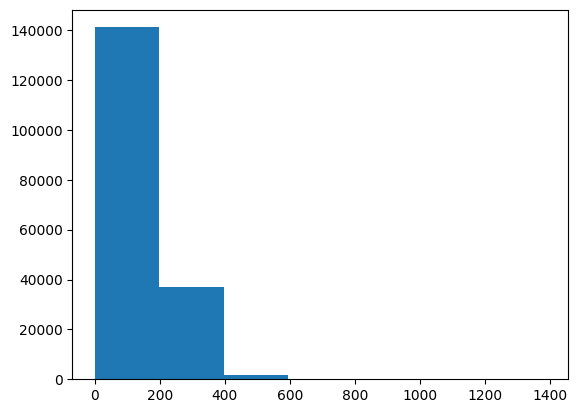

In [65]:


# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [66]:


# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [67]:

# get all teh keyboard char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

In [69]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [70]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
p a t i e n t s   w i t h   i b d   p e r c e i v e   u t i l i t y   i n   g e n e t i c   t e s t i n g   f o r   p r o v i d i n g   i n f o r m a t i o n   r e l e v a n t   t o   f a m i l y   m e m b e r s   ,   a n d   t h i s   a p p r e c i a t i o n   i s   p r o m o t e d   b y   g e n e t i c   l i t e r a c y   .

Length of chars: 140

Vectorized chars:
[[14  5  3  4  2  6  3  9 20  4  3 13  4 22 10 14  2  8 11  2  4 21  2 16
   3  4 12  4  3 19  4  6 18  2  6  2  3  4 11  3  2  9  3  4  6 18 17  7
   8 14  8  7 21  4 10  4  6 18  4  6 17  7  8 15  5  3  4  7  6  8  2 12
   2 21  5  6  3  3  7 17  5 15  4 12 19 15  2 15 22  2  8  9  5  6 10  3
  13  4  9  5 14 14  8  2 11  4  5  3  4  7  6  4  9 14  8  7 15  7  3  2
  10 22 19 18  2  6  2  3  4 11 12  4  3  2  8  5 11 19  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0 

In [71]:
#Create a character embedding

# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
p a t i e n t s   w i t h   i b d   p e r c e i v e   u t i l i t y   i n   g e n e t i c   t e s t i n g   f o r   p r o v i d i n g   i n f o r m a t i o n   r e l e v a n t   t o   f a m i l y   m e m b e r s   ,   a n d   t h i s   a p p r e c i a t i o n   i s   p r o m o t e d   b y   g e n e t i c   l i t e r a c y   .

Embedded chars (after vectorization and embedding):
[[[-0.00363009  0.02720099 -0.03809429 ...  0.04544381  0.00111607
    0.04341772]
  [-0.00278524  0.01820623 -0.04325099 ...  0.0074959  -0.01866475
    0.02912878]
  [-0.02247436  0.01119741  0.03148086 ...  0.04262953 -0.02266033
    0.0142237 ]
  ...
  [-0.03893097 -0.0072946  -0.04697225 ...  0.03731341 -0.0217775
    0.0259085 ]
  [-0.03893097 -0.0072946  -0.04697225 ...  0.03731341 -0.0217775
    0.0259085 ]
  [-0.03893097 -0.0072946  -0.04697225 ...  0.03731341 -0.0217775
    0.0259085 ]]]

Character embedding shape: (1, 290, 25)


In [81]:
inputs = layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same',activation='relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes,activation='softmax')(x)

model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="Model_3_Conv1D_char_embedding")

#compile model
model_3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [82]:
model_3.summary()


Model: "Model_3_Conv1D_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_embed (Embedding)               │ (None, 290, 25)             │           1,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 290, 64)             │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,139 (39.61 KB)

 Trainable params: 10,139 (39.61 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:

# create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [84]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=7,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))



Epoch 1/7
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.4168 - loss: 1.4005 - val_accuracy: 0.5964 - val_loss: 1.0333
Epoch 2/7
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.5953 - loss: 1.0222 - val_accuracy: 0.6453 - val_loss: 0.9298
Epoch 3/7
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.6369 - loss: 0.9308 - val_accuracy: 0.6589 - val_loss: 0.8722
Epoch 4/7
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.6644 - loss: 0.8770 - val_accuracy: 0.6606 - val_loss: 0.8574
Epoch 5/7
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.6752 - loss: 0.8445 - val_accuracy: 0.6769 - val_loss: 0.8404
Epoch 6/7
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.6791 - loss: 0.8337 - val_accuracy: 0.7074 - val_loss: 0.7709
Epoch 7/7
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6833 - loss: 0.8165 - val_accuracy: 0.7048 - val_loss: 0.7867


In [85]:
model_3.evaluate(val_char_dataset)


945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6932 - loss: 0.7916


[0.7982068061828613, 0.6934330463409424]

In [86]:

# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


array([[0.18563047, 0.62212527, 0.05368021, 0.10080293, 0.03776107],
       [0.2058343 , 0.64124495, 0.00157109, 0.14444764, 0.00690189],
       [0.39264017, 0.11767498, 0.0495491 , 0.4246074 , 0.01552837],
       ...,
       [0.00120021, 0.0022923 , 0.01586552, 0.00335805, 0.9772839 ],
       [0.05277158, 0.12446373, 0.19583276, 0.02212518, 0.6048068 ],
       [0.13738142, 0.8086069 , 0.03441015, 0.01236805, 0.00723343]],
      dtype=float32)

In [87]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [88]:

# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_one_hot,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 69.34330729511451,
 'precision': 0.6910748262226283,
 'recall': 0.6934330729511452,
 'f1': 0.6919115863102324}

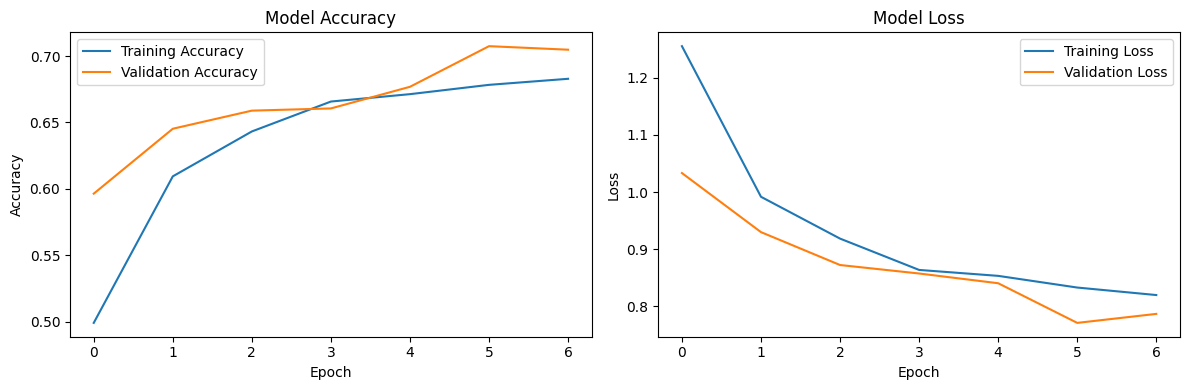

In [89]:
import matplotlib.pyplot as plt

# Retrieve accuracy and loss history from the model
history = model_3_history.history

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step


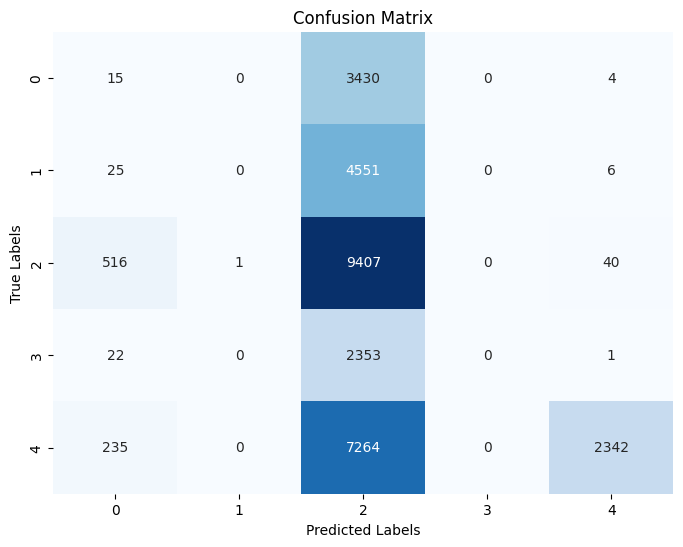

              precision    recall  f1-score   support

           0       0.02      0.00      0.01      3449
           1       0.00      0.00      0.00      4582
           2       0.35      0.94      0.51      9964
           3       0.00      0.00      0.00      2376
           4       0.98      0.24      0.38      9841

    accuracy                           0.39     30212
   macro avg       0.27      0.24      0.18     30212
weighted avg       0.44      0.39      0.29     30212



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Get the true labels and predictions
# Assuming valid_dataset is your validation data and the labels are in the format you can use
y_true = np.concatenate([y for x, y in valid_dataset], axis=0)  # True labels
y_pred = np.argmax(model_3.predict(valid_dataset), axis=1)      # Predicted labels

# Step 2: Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Optional: Show classification report
print(classification_report(y_true, y_pred))


# Model 4 combined char and tokens


In [94]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model

# Define a custom Keras layer to wrap the TensorFlow Hub layer
class HubEmbeddingLayer(layers.Layer):
    def __init__(self, hub_url):
        super(HubEmbeddingLayer, self).__init__()
        self.hub_layer = hub.KerasLayer(hub_url, trainable=False)

    def call(self, inputs):
        return self.hub_layer(inputs)

# Assuming the following URL for the TensorFlow Hub layer
hub_url = "https://tfhub.dev/google/universal-sentence-encoder/4"  # Example for Universal Sentence Encoder

# 1. Token inputs branch
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embedding_layer = HubEmbeddingLayer(hub_url)
token_embeddings = token_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = Model(inputs=token_inputs, outputs=token_output)

# 2. Char inputs branch
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
# Assuming char_vectorizer and char_embed are already defined properly
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Construct the model
model_4 = Model(inputs=[token_model.input, char_model.input],
                outputs=output_layer,
                name="model_4_token_and_char_embeddings")

# Model summary to verify the architecture
model_4.summary()


Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hub_embedding_layer       │ (None, 512)            │              0 │ token_input[0][0]      │
│ (HubEmbeddingLayer)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │          1,750 │ char_vectorizer[2][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         65,664 │ hub_embedding_layer[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50)             │         10,200 │ char_embed[2][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 178)            │              0 │ dense_3[0][0],         │
│ (Concatenate)             │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 178)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 200)            │         35,800 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 200)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 5)              │          1,005 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 114,419 (446.95 KB)

 Trainable params: 114,419 (446.95 KB)

 Non-trainable params: 0 (0.00 B)

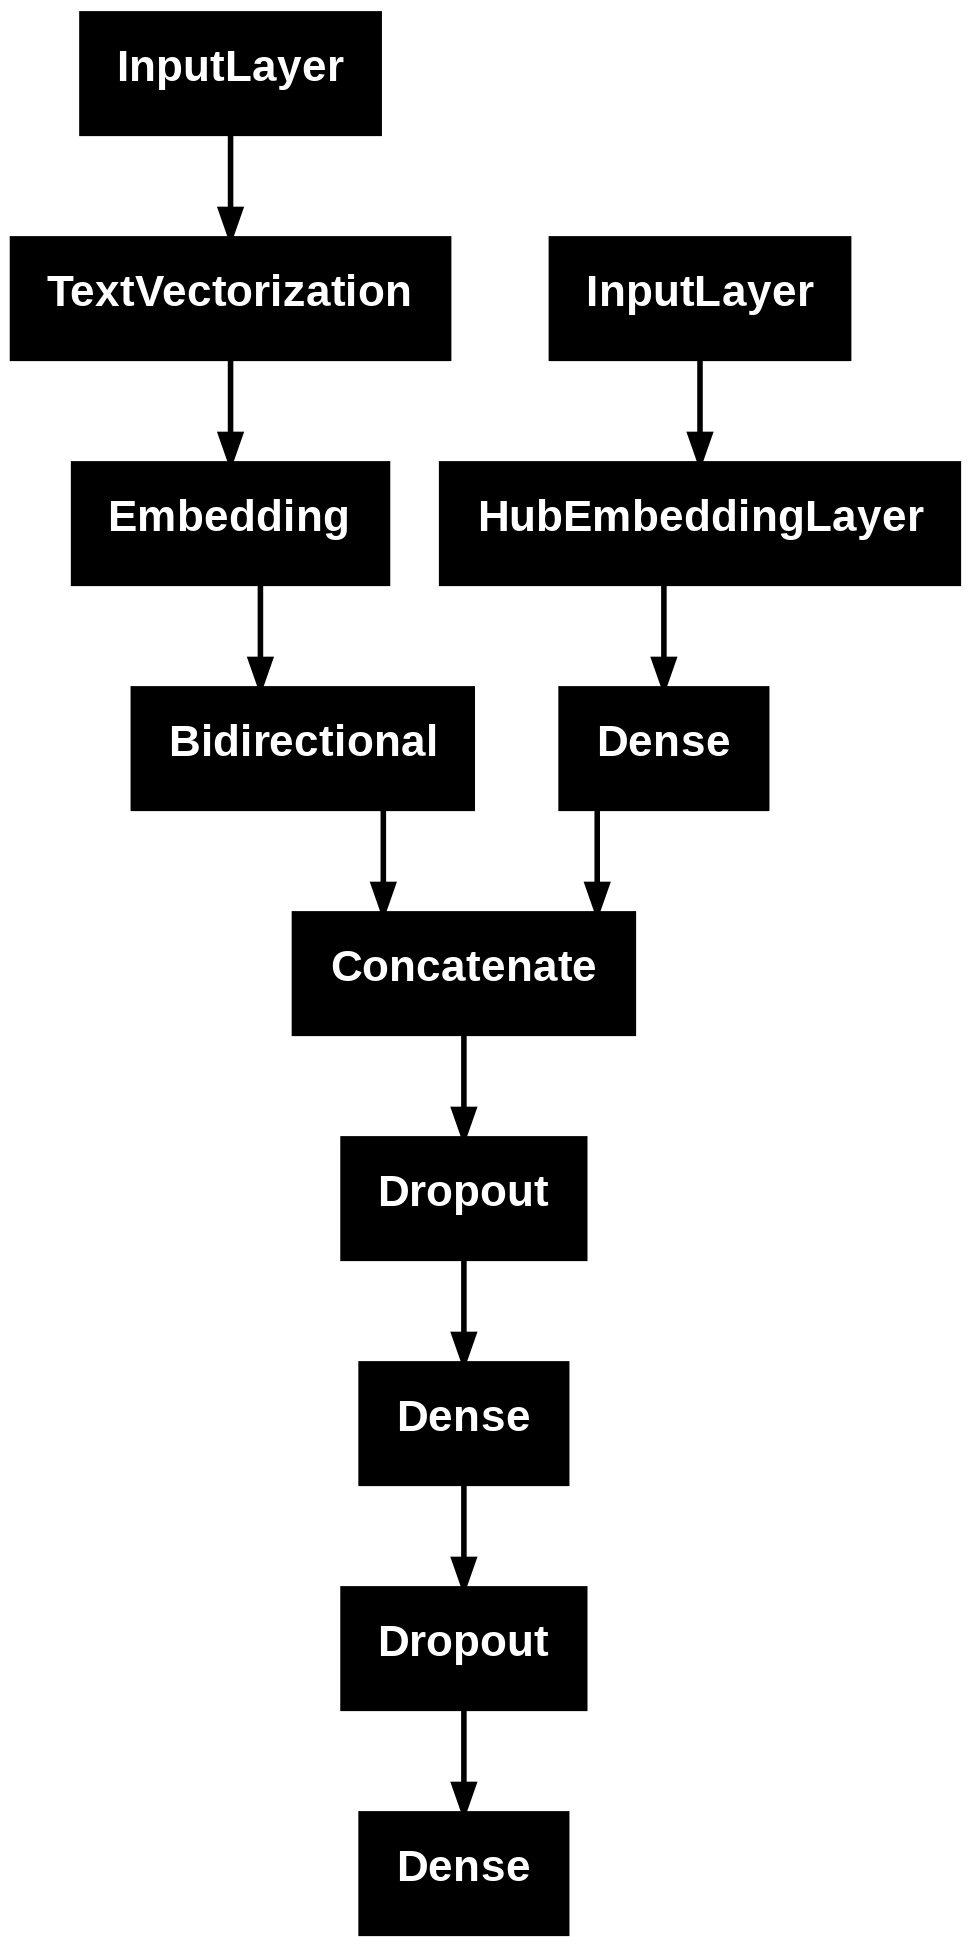

In [95]:

# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [96]:

# Compile token char model
model_4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [97]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [98]:
train_char_token_dataset, val_char_token_dataset


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [99]:

# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=7,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/7
562/562 ━━━━━━━━━━━━━━━━━━━━ 145s 240ms/step - accuracy: 0.5186 - loss: 1.1539 - val_accuracy: 0.6985 - val_loss: 0.7772
Epoch 2/7
562/562 ━━━━━━━━━━━━━━━━━━━━ 132s 236ms/step - accuracy: 0.6953 - loss: 0.7974 - val_accuracy: 0.7277 - val_loss: 0.7169
Epoch 3/7
562/562 ━━━━━━━━━━━━━━━━━━━━ 138s 246ms/step - accuracy: 0.7077 - loss: 0.7668 - val_accuracy: 0.7380 - val_loss: 0.6818
Epoch 4/7
562/562 ━━━━━━━━━━━━━━━━━━━━ 117s 207ms/step - accuracy: 0.7190 - loss: 0.7311 - val_accuracy: 0.7447 - val_loss: 0.6658
Epoch 5/7
562/562 ━━━━━━━━━━━━━━━━━━━━ 121s 215ms/step - accuracy: 0.7227 - loss: 0.7356 - val_accuracy: 0.7440 - val_loss: 0.6707
Epoch 6/7
562/562 ━━━━━━━━━━━━━━━━━━━━ 119s 212ms/step - accuracy: 0.7259 - loss: 0.7226 - val_accuracy: 0.7630 - val_loss: 0.6308
Epoch 7/7
562/562 ━━━━━━━━━━━━━━━━━━━━ 118s 209ms/step - accuracy: 0.7297 - loss: 0.7037 - val_accuracy: 0.7586 - val_loss: 0.6222


In [100]:

# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.7581 - loss: 0.6409


[0.6449979543685913, 0.7545015215873718]

In [101]:

# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs


945/945 ━━━━━━━━━━━━━━━━━━━━ 54s 57ms/step


array([[5.14082491e-01, 3.30588728e-01, 1.08796230e-03, 1.48938850e-01,
        5.30195842e-03],
       [4.72096890e-01, 3.98268312e-01, 3.91656486e-03, 1.24741636e-01,
        9.76575771e-04],
       [4.92660969e-01, 8.14200658e-03, 1.32922083e-02, 4.84121472e-01,
        1.78326119e-03],
       ...,
       [1.21859848e-04, 1.34131452e-03, 1.73691288e-02, 4.90708699e-05,
        9.81118560e-01],
       [6.04595337e-03, 7.21968412e-02, 1.33232594e-01, 3.67634580e-03,
        7.84848273e-01],
       [8.56139958e-02, 8.80098820e-01, 2.77787019e-02, 2.71532871e-03,
        3.79308476e-03]], dtype=float32)

In [102]:

# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [104]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_one_hot,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 75.45015225738118,
 'precision': 0.7560844356016764,
 'recall': 0.7545015225738118,
 'f1': 0.753202348568264}

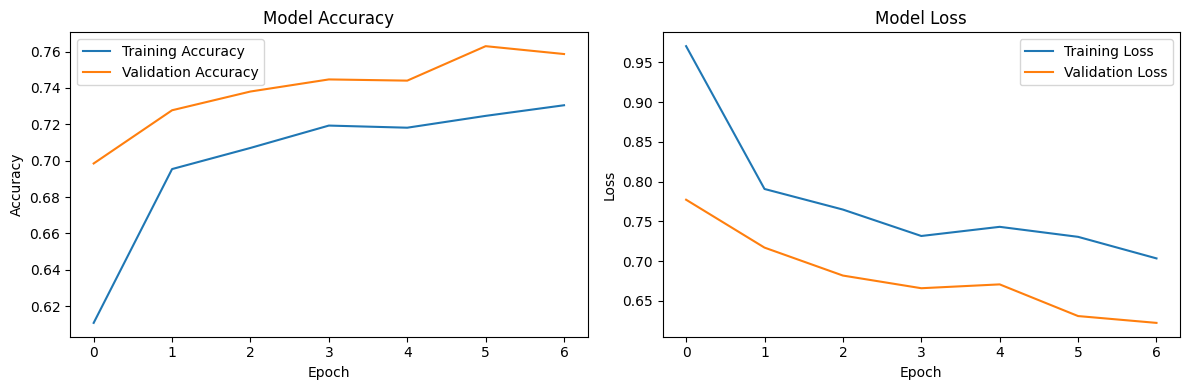

In [105]:
import matplotlib.pyplot as plt

# Retrieve accuracy and loss history from the model
history = model_4_history.history

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# Model 5

In [109]:
train_df.head()


,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


<Axes: ylabel='Frequency'>

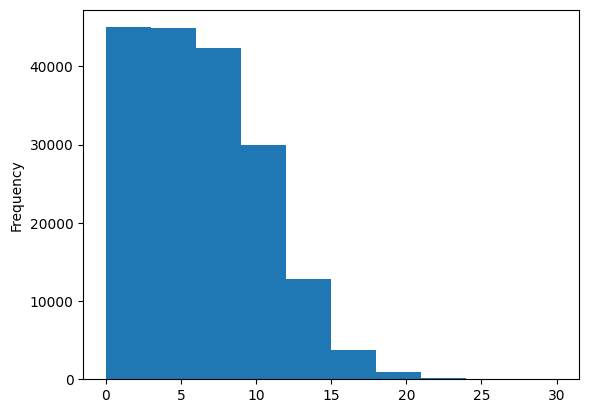

In [110]:
train_df.line_number.plot.hist()


In [111]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [112]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]


(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [113]:
train_df["total_lines"].value_counts()


,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


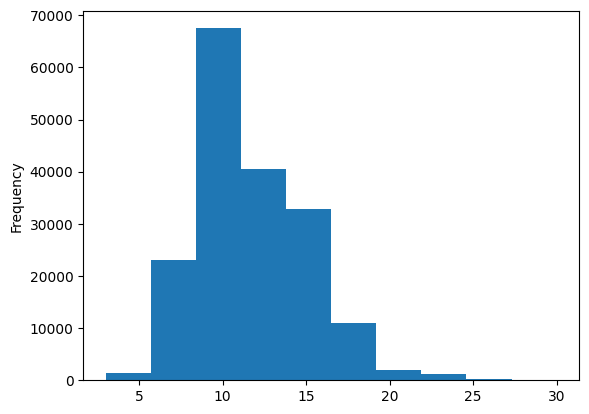

In [114]:
train_df.total_lines.plot.hist();


In [115]:
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples


20.0

In [116]:

# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [117]:
from tensorflow.keras import layers


In [120]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model

# Define a custom Keras layer to wrap the TensorFlow Hub layer
class HubEmbeddingLayer(layers.Layer):
    def __init__(self, hub_url):
        super(HubEmbeddingLayer, self).__init__()
        self.hub_layer = hub.KerasLayer(hub_url, trainable=False)

    def call(self, inputs):
        return self.hub_layer(inputs)

# Assuming the following URL for the TensorFlow Hub layer
hub_url = "https://tfhub.dev/google/universal-sentence-encoder/4"  # Example URL

# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
tf_hub_embedding_layer = HubEmbeddingLayer(hub_url)  # Create instance of the custom layer
token_embeddings = tf_hub_embedding_layer(token_inputs)  # Call the custom layer
token_x = layers.Dense(256, activation="swish")(token_embeddings)
token_x = layers.Dropout(0.50)(token_x)
token_x = layers.Dense(128, activation="swish")(token_x)
token_x = layers.Dropout(0.50)(token_x)
token_outputs = layers.Dense(128, activation="swish")(token_x)
token_model = Model(inputs=token_inputs, outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_x = layers.GlobalMaxPooling1D()(char_embeddings)  # or GlobalAveragePooling1D or Flatten
char_x = layers.Dense(128, activation="swish")(char_x)
char_x = layers.Dropout(0.50)(char_x)
char_output = layers.Dense(128, activation="swish")(char_x)
char_model = Model(inputs=char_inputs, outputs=char_output)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="swish")(line_number_inputs)
x = layers.Dense(32, activation="swish")(x)
line_number_model = Model(inputs=line_number_inputs, outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="swish")(total_lines_inputs)
y = layers.Dense(32, activation="swish")(y)  # Fix: use y instead of total_lines_inputs
total_line_model = Model(inputs=total_lines_inputs, outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(512, activation="swish")(combined_embeddings)
z = layers.Dropout(0.50)(z)
z = layers.Dense(512, activation="swish")(z)
z = layers.Dropout(0.50)(z)
z = layers.Dense(256, activation="swish")(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output, total_line_model.output, z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together the model
model_5 = Model(inputs=[line_number_model.input, total_line_model.input, token_model.input, char_model.input], outputs=output_layer)

# Print model summary to check the architecture
model_5.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hub_embedding_layer_1     │ (None, 512)            │              0 │ token_inputs[0][0]     │
│ (HubEmbeddingLayer)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │        131,328 │ hub_embedding_layer_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │          1,750 │ char_vectorizer[3][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 25)             │              0 │ char_embed[3][0]       │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │         32,896 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 128)            │          3,328 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 128)            │         16,512 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 128)            │         16,512 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid_embedd… │ (None, 256)            │              0 │ dense_8[0][0],         │
│ (Concatenate)             │                        │                │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 512)            │        131,584 │ token_char_hybrid_emb… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 512)            │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_input    

 Total params: 732,795 (2.80 MB)

 Trainable params: 732,795 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

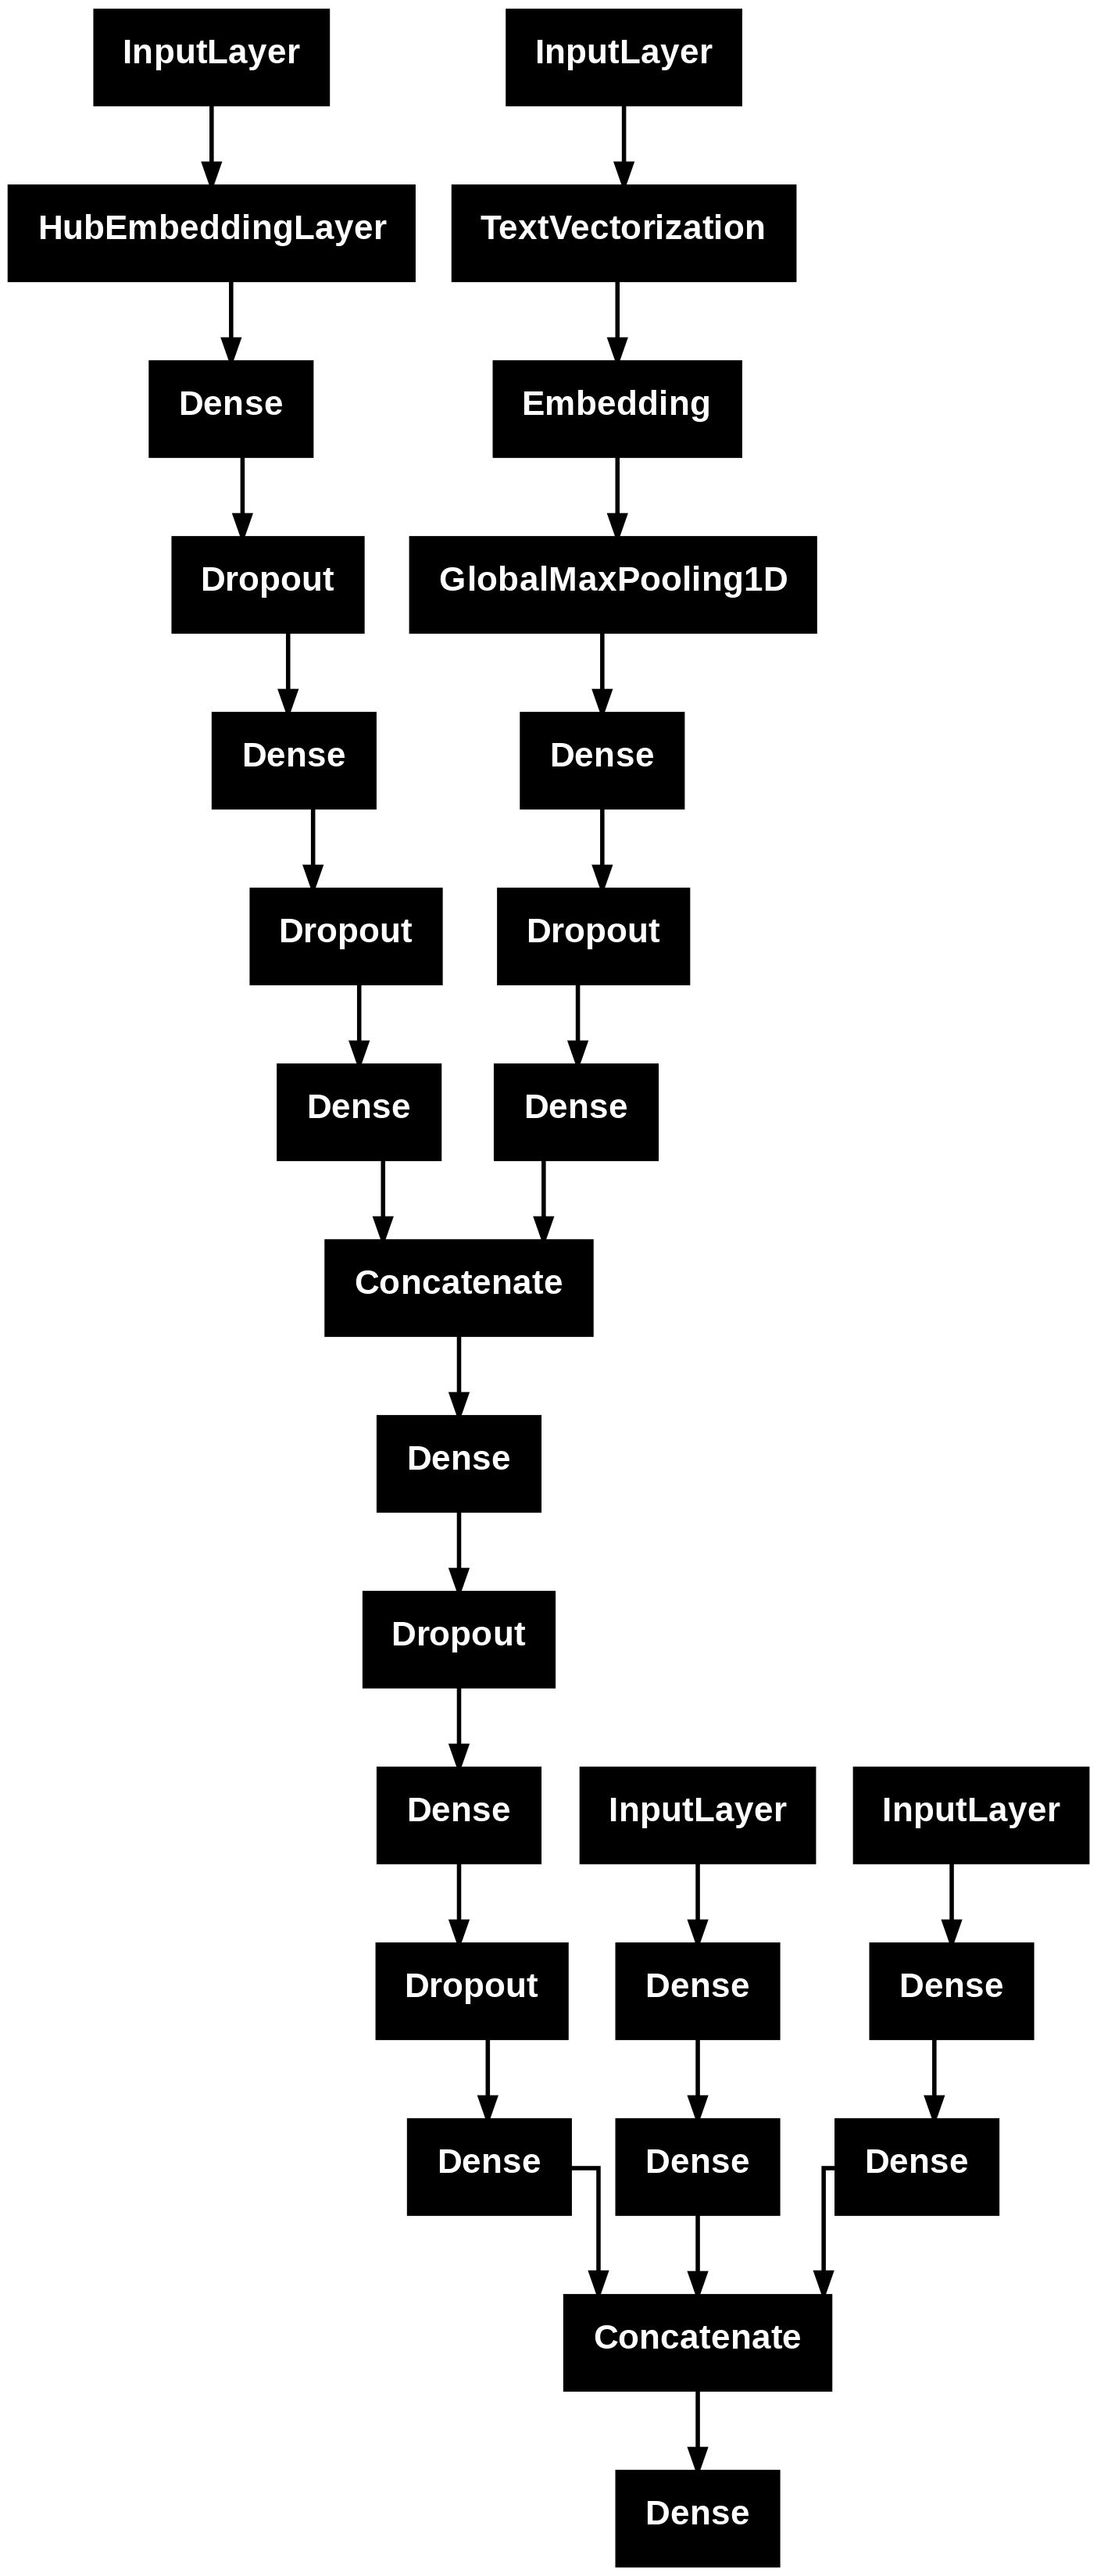

In [121]:

# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)


In [122]:

# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<InputLayer name=token_inputs, built=True> True
<InputLayer name=char_inputs, built=True> True
<HubEmbeddingLayer name=hub_embedding_layer_1, built=True> True
<TextVectorization name=char_vectorizer, built=True> True
<Dense name=dense_6, built=True> True
<Embedding name=char_embed, built=True> True
<Dropout name=dropout_2, built=True> True
<GlobalMaxPooling1D name=global_max_pooling1d_2, built=True> True
<Dense name=dense_7, built=True> True
<Dense name=dense_9, built=True> True
<Dropout name=dropout_3, built=True> True
<Dropout name=dropout_4, built=True> True
<Dense name=dense_8, built=True> True
<Dense name=dense_10, built=True> True
<Concatenate name=token_char_hybrid_embedding, built=True> True
<Dense name=dense_15, built=True> True
<Dropout name=dropout_5, built=True> True
<InputLayer name=line_number_input, built=True> True
<InputLayer name=total_lines_input, built=True> True
<Dense name=dense_16, built=True> True
<Dense name=dense_11, built=True> True
<Dense name=dense_13, buil

In [123]:
initial_learning_rate = 0.001  # Upper bound learning rate for the first epoch
final_learning_rate = 0.00055   # Lower bound learning rate for the last epoch
steps = 8          # Total number of epochs

# Create a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=steps,
    end_learning_rate=final_learning_rate,
    power=1.0,  # Setting power=1.0 for linear decay
    cycle=False  # If True, learning rate keeps decreasing after reaching `final_learning_rate`
)

# Create an optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [126]:

# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=optimizer,
                metrics=["accuracy"])


In [127]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [128]:

# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=10,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.5457 - loss: 1.0765 - val_accuracy: 0.7523 - val_loss: 0.6070
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.7579 - loss: 0.6024 - val_accuracy: 0.7736 - val_loss: 0.5246
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7720 - loss: 0.5617 - val_accuracy: 0.8015 - val_loss: 0.4888
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.7968 - loss: 0.5175 - val_accuracy: 0.8241 - val_loss: 0.4659
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8088 - loss: 0.4961 - val_accuracy: 0.8221 - val_loss: 0.4543
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.8018 - loss: 0.5124 - val_accuracy: 0.8338 - val_loss: 0.4546
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.8153 - loss: 0.4741 - val_accuracy: 0.8145 - val_loss: 0.4694
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.8170 - loss: 0.4811 - 

In [129]:

# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step


array([[4.8922974e-01, 9.9326426e-04, 9.9352575e-05, 5.0959754e-01,
        8.0095131e-05],
       [5.9449023e-01, 7.0996617e-04, 7.8738080e-03, 3.9629713e-01,
        6.2878645e-04],
       [4.7477823e-01, 2.3484973e-03, 3.1641111e-02, 4.7719222e-01,
        1.4039831e-02],
       ...,
       [1.3201688e-04, 6.0706665e-03, 3.8090148e-03, 1.6540635e-06,
        9.8998660e-01],
       [1.8374689e-04, 3.9766207e-01, 9.5407134e-03, 4.6828877e-06,
        5.9260881e-01],
       [3.5040694e-01, 3.0535099e-01, 3.2300550e-01, 5.0208173e-03,
        1.6215699e-02]], dtype=float32)

In [130]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 0, 3, ..., 4, 4, 0])>

In [132]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_one_hot,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.29802727393088,
 'precision': 0.8320853144670747,
 'recall': 0.8329802727393089,
 'f1': 0.8320757922746442}

# Compare model results

In [135]:
all_model_results = pd.DataFrame(
    {
        'model0':baseline_results,
        'model1': model_1_results,
        'model3': model_3_results,
        'model4': model_4_results,
        'model5':model_5_results
    }
)

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model0,72.183238,0.718647,0.721832,0.698925
model1,80.206540,0.802642,0.802065,0.798655
model3,69.343307,0.691075,0.693433,0.691912
model4,75.450152,0.756084,0.754502,0.753202
model5,83.298027,0.832085,0.832980,0.832076


In [136]:
all_model_results.accuracy = all_model_results.accuracy /100

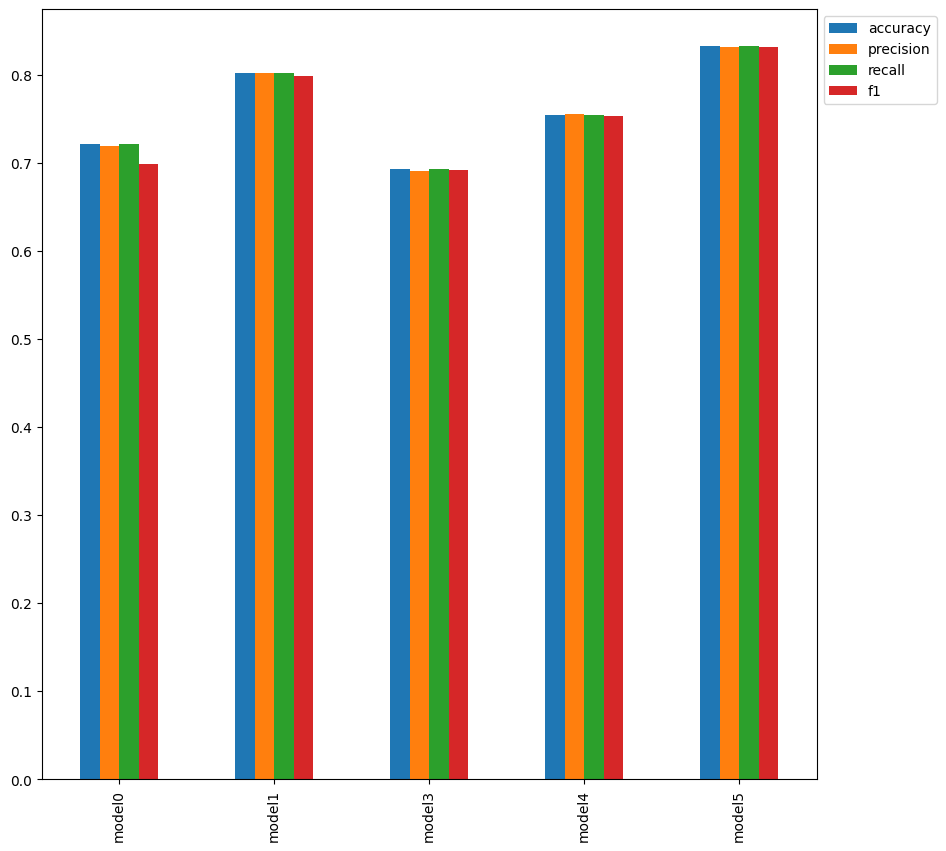

In [137]:
# plot and compare all the results

all_model_results.plot(
    kind='bar',
    figsize = (10,10),

).legend(bbox_to_anchor =(1.0,1.0))

# Save and load the model

In [144]:
model_5.save("model5.keras")


In [148]:
import tensorflow as tf
import tensorflow_hub as hub
from keras.utils import get_custom_objects


In [149]:
# Register the HubEmbeddingLayer
def get_hub_embedding_layer(hub_url):
    return hub.KerasLayer(hub_url, trainable=True, name='hub_embedding_layer')

# You need to register the custom object
get_custom_objects()['HubEmbeddingLayer'] = get_hub_embedding_layer


In [152]:
# Load the saved model
loaded_model = tf.keras.models.load_model(
    "model5.keras",
    custom_objects={'HubEmbeddingLayer': hub.KerasLayer}
)

# Verify the model is loaded correctly
loaded_model.summary()


ValueError: Expected a string, got <KerasTensor shape=(None,), dtype=string, sparse=False, name=token_inputs>

In [153]:
model_5.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hub_embedding_layer_1     │ (None, 512)            │              0 │ token_inputs[0][0]     │
│ (HubEmbeddingLayer)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │        131,328 │ hub_embedding_layer_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │          1,750 │ char_vectorizer[3][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 25)             │              0 │ char_embed[3][0]       │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │         32,896 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 128)            │          3,328 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 128)            │         16,512 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 128)            │         16,512 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid_embedd… │ (None, 256)            │              0 │ dense_8[0][0],         │
│ (Concatenate)             │                        │                │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 512)            │        131,584 │ token_char_hybrid_emb… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 512)            │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_input    

 Total params: 2,198,386 (8.39 MB)

 Trainable params: 732,795 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,465,591 (5.59 MB)